# Linear regression

- hide: true
- toc: true
- comments: true
- categories: [ml, stats]

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer

Notes:

- When will regression do well: when the underlying model is linear. Check KNN vs linear regression comparison.

## Multicollinearity

Load sample dataset

In [4]:
df = (
    sns.load_dataset("titanic")
    .pipe(pd.get_dummies, columns=["sex"])
    .rename(columns=lambda x: x.replace("sex_", ""))
)
df.head(3)

,survived,pclass,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,female,male
0,0,3,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False,0,1
1,1,1,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False,1,0
2,1,3,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True,1,0


Check that female and male are mutually exclusive

In [5]:
df.groupby(["female", "male"]).size().unstack()

male,0,1
female,,
0,NaN,577.0
1,314.0,NaN


Regression specifications

In [6]:
m1 = smf.ols("survived ~ female", data=df).fit()
m2 = smf.ols("survived ~ male", data=df).fit()
m3 = smf.ols("survived ~ male + female -1", data=df).fit()
m4 = smf.ols("survived ~ male + female", data=df).fit()

Stargazer([m1, m2, m3, m4])

In [9]:
m3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               survived   R-squared:                       0.295
Model:                            OLS   Adj. R-squared:                  0.294
Method:                 Least Squares   F-statistic:                     372.4
Date:                Fri, 04 Feb 2022   Prob (F-statistic):           1.41e-69
Time:                        08:53:47   Log-Likelihood:                -466.09
No. Observations:                 891   AIC:                             936.2
Df Residuals:                     889   BIC:                             945.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
male           0.1889      0.017     11.102      0.000       0.156       0.222
female         0.7420      0.023     32.171      0.000       0.697       0.787
==============================================================================
Omnibus:                       25.424   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.169
Skew:                           0.427   Prob(JB):                     1.26e-06
Kurtosis:                       2.963   Cond. No.                         1.36
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
smf.ols("survived ~ ")

df

TypeError: from_formula() missing 1 required positional argument: 'data'

# Example

In [12]:
path = "https://www.statlearning.com/s/Advertising.csv"
cols = ["TV", "radio", "newspaper", "sales"]
df = (
    pd.read_csv(path, usecols=cols)
    .rename(lambda col: col.lower(), axis=1)
    .reset_index()
    .rename(columns={"index": "market"})
)
print(df.shape)
df.head(3)

(200, 5)


,market,tv,radio,newspaper,sales
0,0,230.1,37.8,69.2,22.1
1,1,44.5,39.3,45.1,10.4
2,2,17.2,45.9,69.3,9.3


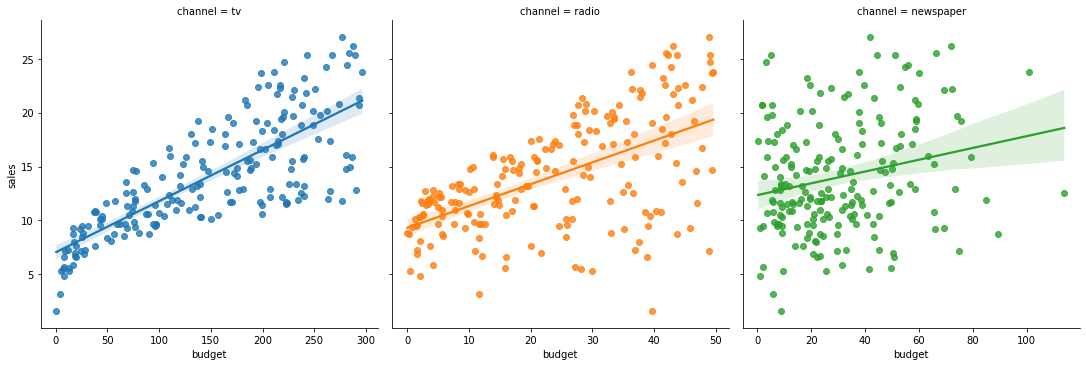

In [14]:
# Inspect data

tidy = df.melt(id_vars=["market", "sales"], var_name="channel", value_name="budget")

sns.lmplot(x="budget", y="sales", hue="channel", col="channel", sharex=False, data=tidy);

# Estimating coefficients

In [19]:
mod = sm.OLS.from_formula("sales ~ tv + radio + newspaper", data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Mon, 15 Mar 2021   Prob (F-statistic):           1.58e-96
Time:                        15:43:14   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9389      0.312      9.422      0.0

# Evaluating accuracy of coefficient estimates

- Hypothesis testing

# Evaluating accuracy of model

### Residual standard error

- The RSE is an estimate of the irreducible error, $\epsilon$, and thus meansures how much, on average, the response will deviate from the true regression line.

- The RSE is 3.25, which implies that our estimates deviate about 3.25 from the actual values (this would be true even if we knew the population parameters, as the RSE is an estimate of the error standard deviation). Given the average value of sales, the percentage error is about 12 percent. Whether this is a lot or not depends on the application. 

- Becaue the RSE is an absolute measure of lack of fit, expressed in units of y, it's not always easy to interpret whether a given RSE is small or large.

In [22]:
rse = np.sqrt(res.scale)
x_mean = df.sales.mean()

print(rse)
print(rse / x_mean)
print(res.rsquared)

1.685510373414744
0.1202004188564624
0.8972106381789522


### $R^2$

- $R^2$, which is a relative measure of lack of fit, and measures the percentage of variance in y that the model can explain (and is thus always between 0 and 1). In the simple linear regression setting, $R^2 = Cor(X, Y)^2$.

- A low $R^2$ can mean that the true relationship is non-linear or that the error variance is very high or both. What constitutes "low" depends on the application.

- In the model above, more than 90 percent of the variation is explained by the set of explanatory variables.

# Multiple linear regression

### Estimating the coefficients

# Questions of interest

## Is there a relationship between the response and predictors?

- To test whether at least one of the predictors is useful in predicting the response, we can look at the reported F statistic.

In [25]:
res.fvalue, res.f_pvalue

(570.2707036590942, 1.575227256092437e-96)

- To test whether a subset of parameters is useful, we can run our own F-test. To manually test for all parameters, we can use:

In [32]:
a = np.identity(len(res.params))[1:]
res.f_test(a)

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[570.27070366]]), p=1.5752272560925203e-96, df_denom=196, df_num=3>

- Which is equivalent to the statistic provided in the output. To test the (joint) usefulness of radio and newspaper, we can use:

In [40]:
a = np.identity(len(res.params))[[2, 3]]
res.f_test(a)

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[272.04067681]]), p=2.829486915701129e-57, df_denom=196, df_num=2>

- Remember: the F statistic is valuable because irrespective of $p$, there is only a 5 percent change that the p-value is below 0.05. In contrast, individual predictors each have that probability, so for a large number of predictors, it's very likely that we observe significant ones solely due to chance.

Are all of the predictors or only a subset useful in explaining y?

## Application

In [12]:
# Overal fit

rse = np.sqrt(res.scale)
x_mean = df.sales.mean()

print(rse)
print(rse / x_mean)
print(res.rsquared)

1.685510373414744
0.1202004188564624
0.8972106381789522


- The RSE is 3.25, which implies that our estimates deviate about 3.25 from the actual values (this would be true even if we knew the population parameters, as the RSE is an estimate of the error standard deviation). Given the average value of sales, the percentage error is about 12 percent. Whether this is a lot or not depends on the application.

- Becaue the RSE is an absolute measure of lack of fit, expressed in units of y, it's not always easy to interpret whether a given RSE is small or large.

- $R^2$, which is a relative measure of lack of fit, and measures the percentage of variance in y that the model can explain (and is thus always between 0 and 1). In the simple linear regression setting, $R^2 = Cor(X, Y)^2$. 

- A low $R^2$ can mean that the true relationship is non-linear or that the error variance is very high or both. What constitutes "low" depends on the application.

- In the model above, more than 90 percent of the variation is explained by the set of explanatory variables.


In [13]:
# Is at least one of the predictors useful in explaining y?

res.fvalue, res.f_pvalue

(570.2707036590942, 1.575227256092437e-96)

In [14]:
# Is a subset of predictors useful?

a = np.identity(len(res.params))[[2, 3]]
res.f_test(a)

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[272.04067681]]), p=2.829486915701129e-57, df_denom=196, df_num=2>

Remember: the F statistic is valuable because irrespective of $p$, there is only a 5 percent change that the p-value is below 0.05. In contrast, individual predictors each have that probability, so for a large number of predictors, it's very likely that we observe significant ones solely due to chance.

### Regression diagnostics

See [this](https://github.com/erykml/medium_articles/blob/master/Statistics/linear_regression_assumptions.ipynb) awesome post.

## Non-standard standard errors

A very useful [post](https://www.vincentgregoire.com/standard-errors-in-python/) by Vincent Grégoire on how to use various standard error adjustment commonly used in economics.

# Sources

- [The hundred-page machine learning book](http://themlbook.com)
- [An introduction to statistical learning](https://www.statlearning.com)